### Standard Imports

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from os import listdir
import warnings
warnings.filterwarnings("ignore")

from pickle import dump
np.random.seed(69420)
import re
from numpy import array
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax


In [ ]:

## TensorFlow libraries ##
import tensorflow
tensorflow.random.set_seed(69420)
tensorflow.keras.utils.set_random_seed(69420)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Convolution2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model




### Loading Data and test train split

In [2]:
from sklearn.model_selection import train_test_split

path = 'flickr8k/images/'
images = listdir(path)

train_size = int(0.9*len(images))
test_size = len(images) - train_size

train = images[:train_size]
test = images[train_size:]

# Loading the pretrainded VGG-19 model

 * VGG-19 is a image classifier.
 * We remove the last softmax layer so get a 1 $\times$ 4096 output.

Here we extract the features and save them to a pickle.

In [3]:
#Splitting the dataset into test and train
def extract_features(train, path):
 model = VGG19()
 model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
 print(model.summary())
 counter = 0
 features = dict()
 for name in train:
    filename = path + name
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = name.split('.')[0]
    features[image_id] = feature
    print(f"img {counter} {name}")
    counter +=1
 return features

#### Extracting the features of the images using the VGG19 model and saving them into a pickel

In [4]:
train_features = extract_features(train, path)
test_features = extract_features(test,path)
dump(train_features, open('features.pkl', 'wb'))

2023-01-29 16:43:26.462992: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-29 16:43:26.463025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anshul-IdeaPad-5-15ITL05): /proc/driver/nvidia/version does not exist
2023-01-29 16:43:26.463720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Natural Language Processsing

In [5]:
import string

# Creates a dictionary of image id and the corresponding to list of its descriptions
def load_descriptions(filename):
	text = open(filename, 'r').read()
	mapping = dict()
	# process lines
	for line in text.split('\n'):
		words = line.split()

		# If there is a line with words less than 2.
		if len(line) < 2:
			continue

		# take the first word as the image id, the rest as the description
		image_id, image_desc = words[0], words[1:]

		# remove file extension from image the id
		image_id = image_id.split('.')[0]

		# convert description words back to string
		image_desc = ' '.join(image_desc)

		if image_id not in mapping:
			mapping[image_id] = list()

		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			# All in small letters
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [re.sub(r'[^\w\s]', '', w) for w in desc]
			# remove blank strings and any other one letter words present
			desc = [word for word in desc if len(word)>1]
			# Take only the alphabetical words in the list
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename =  'flickr8k/captions.txt'
# parse descriptions
descriptions = load_descriptions(filename)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')


Loaded: 8092 
Vocabulary Size: 8680


### Loading the Training features and descriptions

In [6]:
def dataset_desc(dataset_images, descriptions):
	mapping = dict()
	for id, desc in descriptions.items():
		if id in dataset_images:
			dnew = []
			for i in range(len(desc)):
				dnew.append('startseq '+ desc[i] + ' endseq')
			mapping[id] = dnew
	return mapping

training_img = [w.split('.')[0] for w in train]
testing_img = [w.split('.')[0] for w in test]

train_descriptions = dataset_desc(training_img, descriptions)    
test_descriptions = dataset_desc(testing_img, descriptions)


### Processing the image and the caption statement.

In [7]:
# Gives a list of all the words present in the descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Tokenize the descriptions into words 
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

## Get the total words that are present in the vocabulary
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# calculate the length of the description with maximum number of words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	for desc in desc_list:
		# Encode the sequence 
		seq = tokenizer.texts_to_sequences([desc])[0]
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

Vocabulary Size: 8307


### Adding LSTM layers to the VGG model

In [8]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = concatenate([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model_final = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model_final.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model_final.summary())
	return model_final

### Creating a data generator to be fed into the model and saving the trained Model

In [9]:
# Used for model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

# Tokenizer for creating the words
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

# Maximum number of words in a line or sentence
mx_length = max_length(train_descriptions)

# Defining the final Model
model = define_model(vocab_size, mx_length)

# train the model, run epochs manually and save after each epoch
epochs = 2 
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, mx_length)
	# fit for one epoch
	model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)
	model.save('model.h5')
# save model
model.save('model.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 256)      2126592     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_3[0][0]']                
                                                                                            

### Creating Functions for caption generation and Model Evaluation

In [10]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image from the trained model
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


### Calculating BLEU score of the model

In [11]:
# Load the model with the minimum loss and then 
filename = 'model.h5'
model_eval = load_model(filename)
# evaluate model
evaluate_model(model_eval, test_descriptions, test_features, tokenizer, mx_length)

BLEU-1: 0.575361
BLEU-2: 0.317520
BLEU-3: 0.215497
BLEU-4: 0.102083


In [21]:
test_images = extract_features(['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg'], './')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Testing the model for random images.

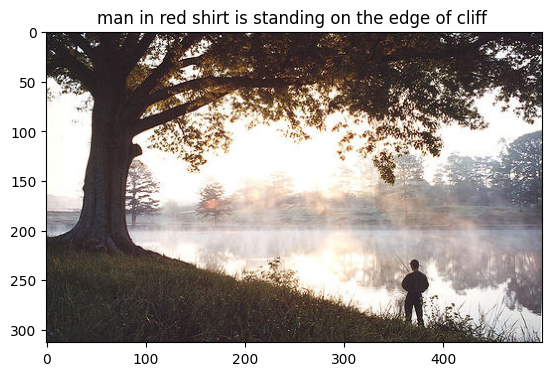

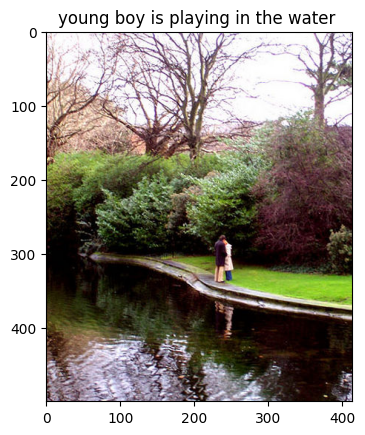

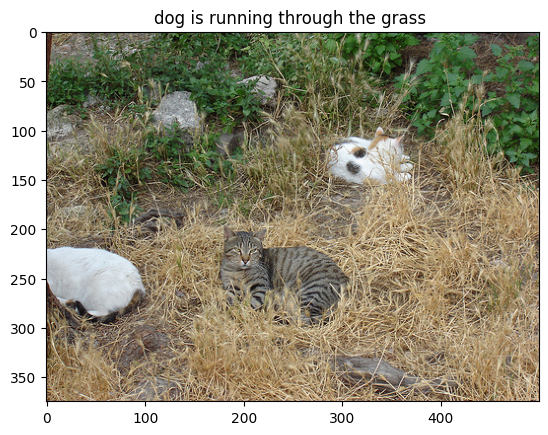

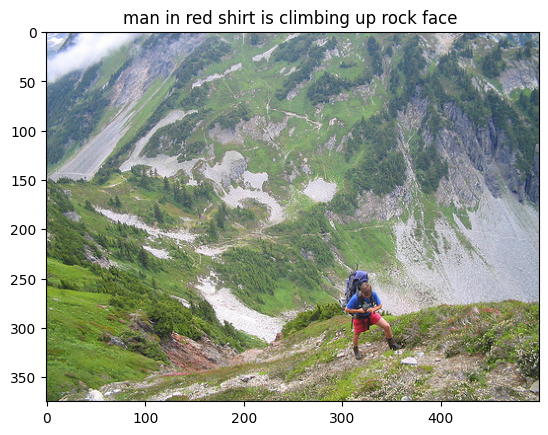

In [30]:
def show_image_and_captions(images):
    for a in images.keys():
        plt.title(generate_desc(model_eval, tokenizer, images[a], mx_length)[9:-6])
        im = mpimg.imread('./' + str(a) + '.jpg')
        plt.imshow(im)
        plt.show()
show_image_and_captions(test_images)